# SDR Theory & Practice in Python

These notes are a refresher in software defined radio (SDR) & digital signal processing (DSP) concepts, as well as use of Juypter notebooks. 

I am using Python rather than the usual C/gnuradio so I can follow along to https://pysdr.org/ and use the Juypter notebook format. For more in-depth content & better explanations, please refer to that source. These notes are merely a poor replica of the original ***but*** with my own issues, explanations & misunderstandings added.


# Theory:

## An RF Signal

Firstly, we generate an example RF signal, that is, a simple signal in the time-domain.

### Some brief notes on the RF spectrum.

Though the carrier frequency for an RF signal generally lies between 20 kHz and 300 GHz, most common radio signals are produced between 100 MHz and 6 GHz. Radar & satellites use frequencies higher than 6 GHz. And the 5G mm-wave signal is 24 - 29 GHz.

The simulated sample period for this mock signal is 1e-06 seconds.
For this signal with frequency = 5000.0, we require SR >= 10000.0 (we have SR = 1000000.0), see discussion below.

The snr of this signal is 49.140395745414835, or in dB 33.82877299377983.


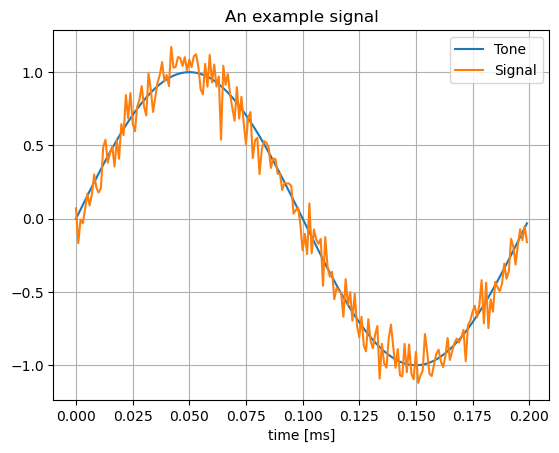

In [4]:
import numpy as np
from matplotlib import pyplot as plt

####################################################

# Sample rate
sr = 1e6    # 1 MHz
print(f'The simulated sample period for this mock signal is {1/sr} seconds.')
# Number of samples, the FFT size, best performance when an order of 2
N = 2048 #1024

# The temporal points
t = (1/sr)*np.arange(N) # 1 /sr is the sample period * number of points = time
# tone frequency
freq = 5e3     # [Hz]

print(f'For this signal with frequency = {freq}, we require SR >= {2*freq} (we have SR = {sr}), see discussion below.')

# basic tone signal
tone = np.sin(freq*2*np.pi*t)

# basic noise
noise = 0.1*np.random.randn(len(t))

####################################################
# signal-to-noise ratio:

snr = np.var(tone) / np.var(noise)

print(f'\nThe snr of this signal is {snr}, or in dB {10*np.log10(snr**2)}.')

# signal
s = tone + noise
####################################################

plt.plot(t[:200]*1000, tone[:200], label='Tone')
plt.plot(t[:200]*1000, s[:200], label='Signal')
plt.xlabel('time [ms]')

plt.title('An example signal')
plt.legend()
plt.grid(True)
plt.show()

In this plot, we show only the first 200 sample points. 

The signal itself is the tone plus some white noise, where the snr, the ratio of tone to noise is set above.


### Note:

Note that, in general, the sample rate must be at least twice the frequency of the maximum frequency component, since in order to avoid aliasing, the Nyquist theorem states that the minimum sample rate is twice the maximum signal frequency, *ie*

```
SR > 2*B
```

where B is the bandwidth of the signal.



## Down-conversion

It is partly because of this requirement, that given a nomial RF signal, it is prudent to down-convert the carrier frequency to a more managable one, such as a the DC signal (in the direct conversion case, see below), reducing the required sampling rate.

There are three common types of down-conversion:

- Direct conversion *a.k.a.* Zero IF. The signal is shifted down such that the carrier frequency is zero (*ie* DC). This is the receiver architecture used by most SDR chips. It may lead to the 'DC spike' *a.k.a. 'DC Offset' artifact, *a.k.a.* LO (local oscillator) leak. This artifact may be eliminated by off-tuning and frequency shifting.

    
    
- Superheterodyne down-conversion. The signal is down-converted to a non-zero intermediate frequency (IF).



- Direct sampling *a.k.a.* Direct RF. No down-conversion is performed which requires a high performance analog-to-digital convertor (ADC).
    

## Window Functions


Although the ideal tone is periodic, with the introduction of noise and/or digitial sampling, this property is likely lost. 

The Fast Fourier Transform requires periodicity however. So we can ensure it by the use of window functions. That is, we apply a windowing function to ensure the cyclic-ness of the signal.

Note: `gqrx` features (under FFT settings0 the following window functions: ``` Hamming, Hann, Blackman, Rectangular, Kaiser, Blackman-Harris, Bartlett, Flattop ```



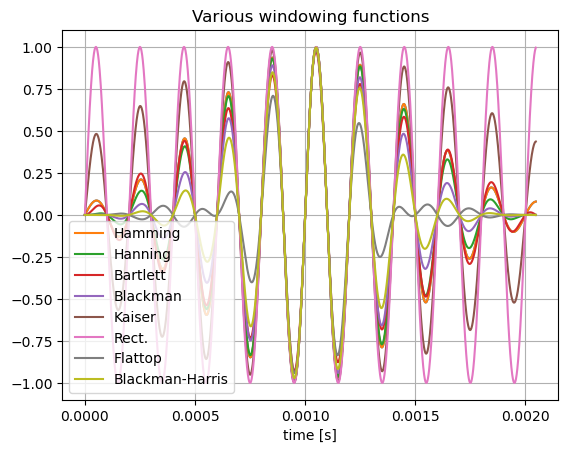

In [32]:
from scipy import signal

# those that come with numpy:
s_ham = tone * np.hamming(N)
s_han = tone * np.hanning(N)
s_bar = tone * np.bartlett(N)
s_bla = tone * np.blackman(N)

# note the second parameter, beta, for kaiser
# beta = 0 => rectangular, beta = 8 => blackman
beta = 2
s_kais = tone * np.kaiser(N, beta)

# other (included in scipy.signals & gqrx)
s_rect = tone * np.kaiser(N, 0)
s_flattop = tone * signal.windows.flattop(N)
s_bh = tone * signal.windows.blackmanharris(N)


plt.figure(0)
plt.plot(t,s)
plt.plot(t,s_ham, label='Hamming')
plt.plot(t,s_han, label='Hanning')
plt.plot(t,s_bar, label='Bartlett')
plt.plot(t,s_bla, label='Blackman')
plt.plot(t,s_kais, label='Kaiser')
plt.plot(t,s_rect, label='Rect.')
plt.plot(t,s_flattop, label='Flattop')
plt.plot(t,s_bh, label='Blackman-Harris')

#
plt.title('Various windowing functions')
plt.legend()
plt.grid(True)
plt.xlabel('time [s]')
plt.show()

#
s = s_ham


## Power

We can calculate the power of our signal. In general the formula is:

In [3]:
avg_pwr = np.mean(np.abs(s)**2)
print(f'The average power of our signal is {avg_pwr}')

The average power of our signal is 0.20462137101046707


However, if the mean is zero, then we can use the variance formula, such that

In [4]:
avg_pwr = np.var(s)
print(f'Assuming a zero mean, the average power of our signal is {avg_pwr}')

Assuming a zero mean, the average power of our signal is 0.2046166380938287


## The Fast Fourier Transform & Spectrograms

Now let's get S, the signal in the fequency-domain, the fourier transform of s. 

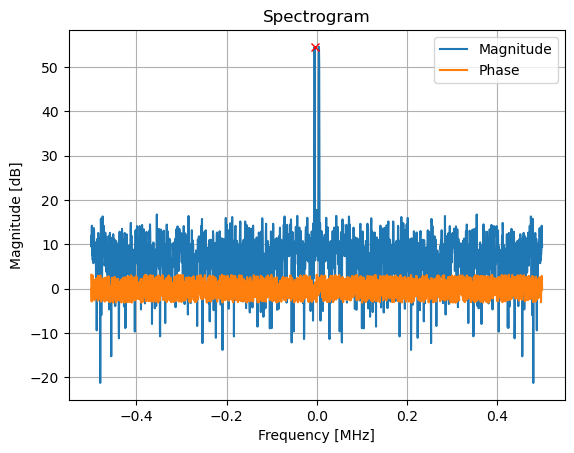

In [5]:
# Shifted so the array is correctly centered aroud the DC frequency
#S = np.fft.fft(s)
S = np.fft.fftshift(np.fft.fft(s))
# x-axis:
f = np.arange(sr/-2, sr/2, sr/N) / 1e6 # plot in MHz units

# S will be array of complex numbers:
# print(S)
# 
S_mag = np.abs(S)
S_phase = np.angle(S)

# convert S_mag to dB
S_db = 10*np.log10(np.abs(S)**2)

#
plt.figure(1)
plt.plot(f,S_db, label='Magnitude')
plt.plot(f,S_phase, label='Phase')

# plot the maximum point:
plt.plot(f[np.argmax(S_db)], np.max(S_db), 'rx')

#
plt.title('Spectrogram')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

In the above in blue is the magnitude (the absolute value) of the signal in the frequency-domain, as calculated by the Fast Fourier Transform algorithm - while in orange is the phase of this complex variable, just for fun - note this later value has not been transformed to a dB scaling like the former.

The amplitude of the FFT complex variable is the strength of the signal at that frequency (where the frequency is given by the x co-ordinate), the phase component is the delay, or time shift, required for the frequency to reconstruct the original signal.  



***********************

In the below we create a spectrogram or static waterfall-like plot.

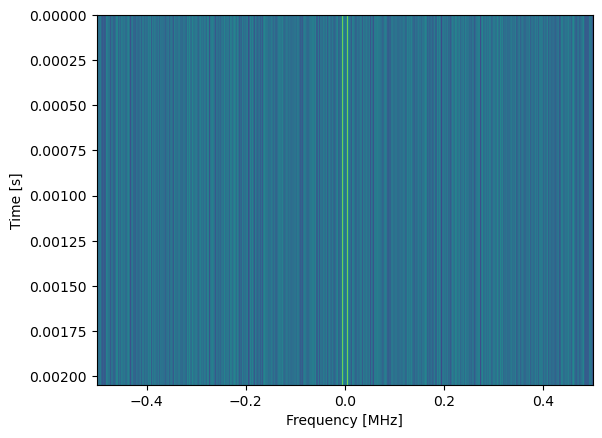

In [19]:

fft_size = N     # FFT size is the sample size.
num_rows = len(s) // fft_size # // is an integer division which rounds down, recall s is the signal in time

# initialise empty array
spectrogram = np.zeros((num_rows, fft_size))

#
for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(s[i*fft_size:(i+1)*fft_size])))**2)

plt.imshow(spectrogram, aspect='auto', extent = [sr/-2/1e6, sr/2/1e6, len(s)/sr, 0])

#
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()

## Power Spectral Density (PSD)

To find the PSD, 6 steps must be performed.
1. Take the FFT
2. Get the magnitude
3. Get the power (square the magnitude)
4. Normalise the power (divide by size & sample rate)
5. Convert to dB scale
6. Shift the FFT to center of 0 Hz.

In order to demonstrate the PSD, we will re-perform some of which we have already done above, *e.g.* emulate a signal, take the FFT, *etc.*


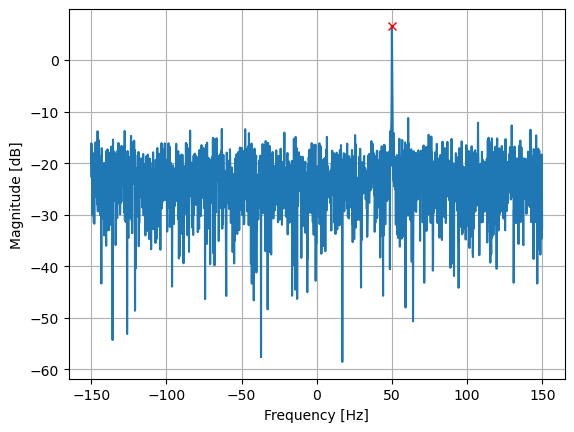

In [7]:
# Signal parameters:
Fs = 300 # sample rate
Ts = 1/Fs # sample period
N = 2048 # number of samples to simulate

# x & t vectors:
t = Ts*np.arange(N)
x = np.exp(1j*2*np.pi*50*t) # simulates sinusoid at 50 Hz

# Noise component:
n = (np.random.randn(N) + 1j*np.random.randn(N))/np.sqrt(2) # complex noise with unity power
noise_power = 2

# The signal plus noise:
r = x + n * np.sqrt(noise_power)

# Calculate the PSD (the normalised, real component FFT)
PSD = np.abs(np.fft.fft(r))**2 / (N*Fs)
# Convert to dB
PSD_log = 10.0*np.log10(PSD)
# Shift centre
PSD_shifted = np.fft.fftshift(PSD_log)
# Construct the x-axis
f = np.arange(Fs/-2.0, Fs/2.0, Fs/N) # start, stop, step

plt.plot(f, PSD_shifted)

# plot the maximum point:
plt.plot(f[np.argmax(PSD_shifted)], np.max(PSD_shifted), 'rx')

#
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.show()


## IQ Sampling

Use an orgothonal basis of periodic functions such that:
$$
x(t) = I \cos(2 \pi f t) + Q \sin(2 \pi f t)
$$
where the first component is the in-phase term and the second is the out-of-phase (*a.k.a.* quadrature) term, and recall:
$$
 a \cos(x) + b \sin(x) = A \cos(x - \phi)
$$

Therefore, we can create our signal $s(t)$, no matter the phase and amplitude $(\phi, A)$, by adjusting the two amplitude components (I, Q) of the orthognal basis.

Now associate the in-phase component, I, with the real component of an imaginary number, and the quadrature componet, Q, with the imagninary component, and we are back to complex numbers.

## Digital Modulation

In the relm of digital modulation, there are 4 kinds: amplitute shift keying (ASK), phase shift keying (PSK) & frequency shift keying (FSK), plus, quadrature amplitude modulation (QAM), which is a combination of AKS and PKS.  

QAM, ASK & PSK are commonly represented IQ plots *a.k.a.* constellations. Note that FSK can not be represented this way.

Due to the symmetry of the constellations, there is an ambiguity which can be resolved by including pilot symbols into the data stream, or by applying differential coding at the symbol level (an XOR operation, which requires one arbitrary starter symbol).

In the following, we generate an example constellation for a QPSK encoded signal:

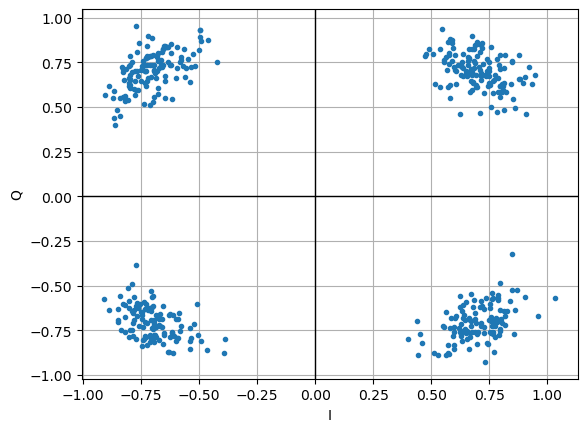

In [8]:

num_symbols = 500

x_int = np.random.randint(0, 4, num_symbols) 
x_degrees = x_int*360/4.0 + 45 
x_radians = x_degrees*np.pi/180.0 
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) 

# additive white Gaussian noise
n = (np.random.randn(num_symbols) + 1j*np.random.randn(num_symbols))/np.sqrt(2) # AWGN with unity power
noise_power = 0.01

# phase noise
phase_noise = np.random.randn(len(x_symbols)) * 0.1 # adjust multiplier for "strength" of phase noise

# new signal with both awgn & phase noise
r = x_symbols* np.exp(1j*phase_noise) + n * np.sqrt(noise_power)
plt.plot(np.real(r), np.imag(r), '.')

# set axes lines to emphasis quadrants
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('I')
plt.ylabel('Q')

plt.grid(True)
plt.show()

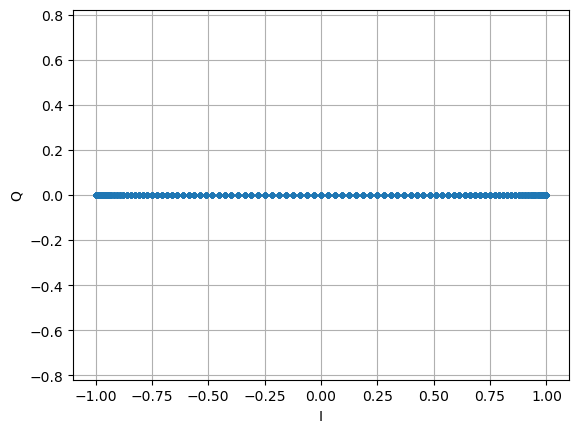

In [39]:
# for comparison, here is the IQ plot of the simple tone:
t = tone

plt.plot(np.real(t), np.imag(t), '.')

plt.xlabel('I')
plt.ylabel('Q')

plt.grid(True)
plt.axis('equal')
plt.show()


Not very interesting of course, this is becuase our tone is all real!

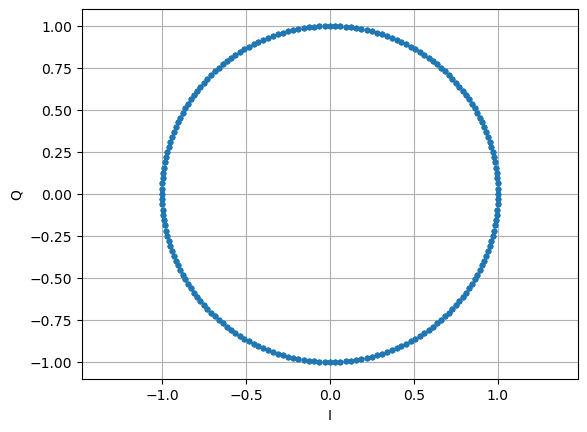

In [40]:
# A more interesting example:


# Define parameters
fs = 1000  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
freq = 5  # Frequency of the tone

# Generate the tone as a complex signal
signal = np.exp(1j * 2 * np.pi * freq * t)

plt.plot(np.real(signal), np.imag(signal), '.')

plt.xlabel('I')
plt.ylabel('Q')

plt.grid(True)
plt.axis('equal')
plt.show()


Also, not that interesting, but that's to be expected given that there is no encoding, or noise.

## Noise

In the above, we have introduced two types of noise to our signal: additative white Gaussian noise, and phase noise. 

The former, Gaussian noise, takes the same form in both the time-domain and frequency-domain. This is demonstrated below:

In order to generate complex noise, with unity power, consider

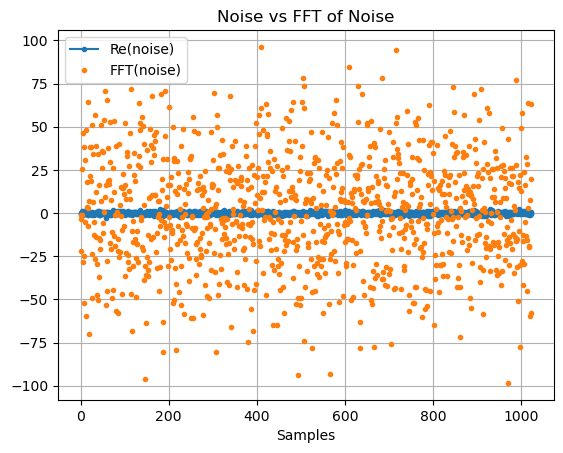

The noise power of this noise is 1.0312205067061546. This value should be approximatly 1.


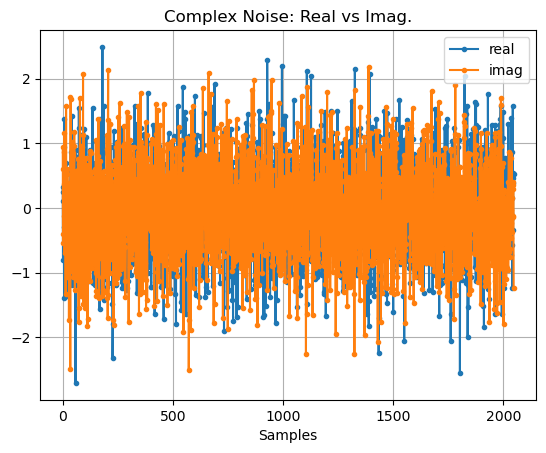

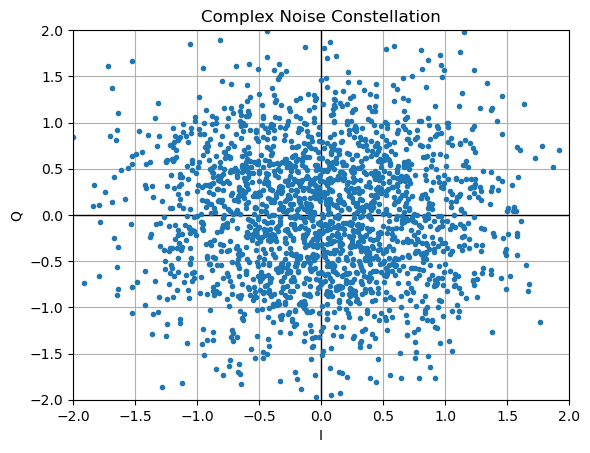

In [9]:
N = 2048 # number of samples to simulate

n = (np.random.randn(N) + 1j*np.random.randn(N))/np.sqrt(2)

# consider the FFT of the noise
X = np.fft.fftshift(np.fft.fft(n))
X = X[N//2:] # only look at positive frequencies.
plt.plot(np.real(n[:N//2]), '.-', label='Re(noise)') # for comparison only plot the first half
plt.plot(np.real(X), '.', label='FFT(noise)')
plt.grid(True)
plt.title('Noise vs FFT of Noise')
plt.xlabel('Samples')
plt.legend()
plt.show()


# check the noise power:
noise_power = np.var(n)

print(f'The noise power of this noise is {noise_power}. This value should be approximatly 1.')

# plot the real and imaginary components of the complex noise against the sample
plt.plot(np.real(n),'.-', label='real')
plt.plot(np.imag(n),'.-', label='imag')
plt.legend()
plt.grid(True)
plt.title('Complex Noise: Real vs Imag.')
plt.xlabel('Samples')
plt.show()

# plot the IQ constellation of the complex noise
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.plot(np.real(n),np.imag(n),'.')
plt.grid(True, which='both')
plt.axis([-2, 2, -2, 2])
plt.title('Complex Noise Constellation')
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

## Filters

A filter in the time-domain is a ***impulse response***, represented by a 'tap' (h). The tap is an array of floats, with size no larger than 100 elements. Symmetrical filters have purely real tap elements, while asymmetry requires complex values. The thickness of the transistion width is determined by the size of h.

- Note: FIR = Finite Impulse Response



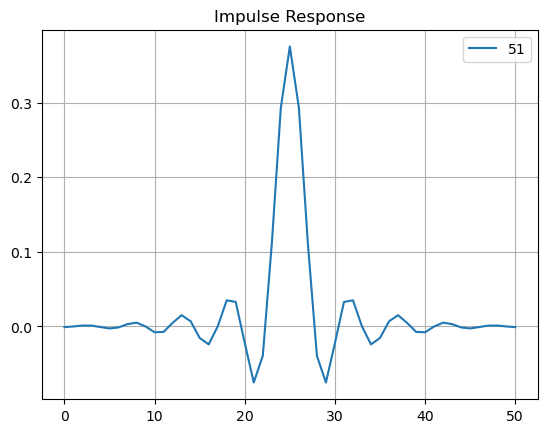

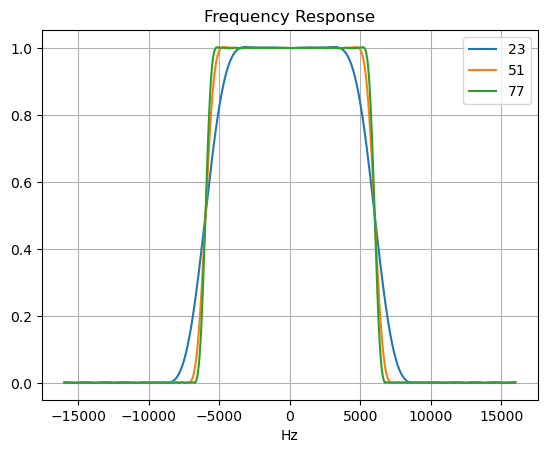

In [39]:
from scipy import signal

############################

cut_off = 3000 # Hz
sample_rate = 32000 # Hz
fs = sample_rate/2

############################

# use scipy signal processing library to get taps
num_taps = 23 # taps should have an odd number
h_23 = signal.firwin(num_taps, cut_off, fs=sample_rate/2)

num_taps = 51 # taps should have an odd number
h_51 = signal.firwin(num_taps, cut_off, fs=sample_rate/2)
# print(h_51)

num_taps = 77 # taps should have an odd number
h_77 = signal.firwin(num_taps, cut_off, fs=sample_rate/2)

############################

# plot the impulse response
plt.plot(h_51, label='51')
plt.grid(True)
plt.legend()
plt.title('Impulse Response')
plt.show()

############################

# plot the frequency response
H_23 = np.fft.fftshift(np.abs(np.fft.fft(h_23, 1024))) # make 0 Hz in the center
w_23 = np.linspace(-sample_rate/2, sample_rate/2, len(H_23)) # x axis
plt.plot(w_23, H_23, label='23')

H_51 = np.fft.fftshift(np.abs(np.fft.fft(h_51, 1024))) # make 0 Hz in the center
w_51 = np.linspace(-sample_rate/2, sample_rate/2, len(H_51)) # x axis
plt.plot(w_51, H_51, label='51')

H_77 = np.fft.fftshift(np.abs(np.fft.fft(h_77, 1024))) # make 0 Hz in the center
w_77 = np.linspace(-sample_rate/2, sample_rate/2, len(H_77)) # x axis
plt.plot(w_77, H_77, label='77')
plt.grid(True)
plt.legend()
plt.xlabel('Hz')
plt.title('Frequency Response')
plt.show()

## Practice I. Hardware:



## RTL-SDR

### General Properties:

These are generally considered the cheapest (& hence most accessible) of the SDR devices/dongles. They modifications/extensions of the Realtek RTL2832U chip which were designed for terrestial digital video broadcasting (DVB-T) reception.



### Linux Installation: Useful commands

I found myself coming back to the following commands

`dmesg` for analysis of the kernel ring buffer, very useful for error checking.

`lsusb` lists the usb (universal serial bus) devices. A rtl-sdr device will appear, if properly connected, here in output as `Realtek Semiconductor Corp. RTL2838 DVB-T` with `ID 0bda:2838` (probably). Note the id is a vendor (0bda) and product code (2838).

`lspci` lists the pci (peripheral component interconnect) devices.


### Nooelec Smart

'smart' = 'sma' connector type + 'r' (receiver) + 't' (bias-tee, power).

#### Installation & Issues:

I tried and failed to set-up this one using the guide found here: https://www.nooelec.com/store/downloads/dl/file/id/72/product/0/nesdr_installation_manual_for_ubuntu.pdf

I had several reoccuring errors which froze the device after a few moments or minutes of operation (or also on any movement). The most common errors besides constant USB disconnects (& reconnects) that occured in dmesg were something like:

`device descriptor read/64, error -71`

I tried several changes to the install to get it to work. Eventually, I sent the an email to the manufacture & they offered to send me a new one. But my final install process which worked goes along these lines:

- Black list the default drivers by creating a file called `rtlsdr-blacklist.conf` in `/etc/modprobe.d/`, containing (note the different filename & the extra lines is suggested in the Nooelec install guide):
```
blacklist dvb_usb_rtl28xxu
blacklist rtl2832
blacklist rtl2830
blacklist dvb_usb_rtl2832u
blacklist dvb_usb_v2
blacklist dvb_core
```

- Next I created a file ` /etc/udev/rules.d/10-rtl-sdr.rules` containing:
```
SUBSYSTEM=="usb", ATTRS{idVendor}=="0bda", ATTRS{idProduct}=="2838", MODE="0666"
```
Then refreshed the udev by:
```
sudo udevadm control --reload-rules
sudo udevadm trigger
```

- Then I also did, as recommended here: https://ubuntuforums.org/showthread.php?t=797789
```
echo -1 >/sys/module/usbcore/parameters/autosuspend
```

- And...


Not in the spirit of science, I didn't test with incremental changes, so I don't know what actually fixed it.





### Blog V4: 

#### Installation & Issues:

I followed the instructions here: https://www.rtl-sdr.com/V4/ under the **Alternative Debian Package Installation Method** and had no issues. 


### A quick aside about usb devices:

...

## Practice II. pyrtlsdr:

pyrtlsdr is a python library wrapper to librtlsdr that itself is a C (& C#) library for using RTL2832U chips.


The following code-cell runs a test to see if the connected dongle can be accessed or is not busy (in use by GQRX perhaps...). 

Found Rafael Micro R828D tuner
RTL-SDR Blog V4 Detected


Valid gain values: [0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]
Number of samples: 1024


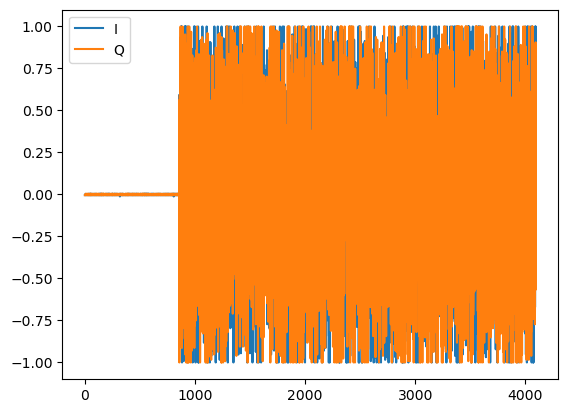

In [14]:
from rtlsdr import RtlSdr

sdr.close() # in case crashed 

# connect to device (this prints device name if no issues)
sdr = RtlSdr()

# set sample properties
sdr.sample_rate = 2.048e6 # Hz

sdr.center_freq = 100e6   # Hz

#Frequency correction
sdr.freq_correction = 60  # PPM (parts per million)
#across the spectrum there is a linear offset in frequency which should be accounted for & corrected
# 2 ppm => freq = center + center * (2/(1e6))

sdr.gain = 'auto'         # enable automatic gain control
# out of interest the following shows the range of valid gain values:
print(f'Valid gain values: {sdr.valid_gains_db}')

# Note to manually set a fixed gain, run, e.g.
# sdr.gain = 49.6

# confirm samples are not being dropped
print(f'Number of samples: {len(sdr.read_samples(1024))}')

# now take some actual data
x = sdr.read_samples(4096)

# close to avoid glitching among other stuff
sdr.close()

#matplotlib, note the shitty first chunk of data

plt.plot(x.real)
plt.plot(x.imag)
plt.legend(["I", "Q"])
plt.show()




## MORE EXAMPLES HERE WOULD BE GOOD.

# An Example from pysdr.com

********************

The following can be ignored...

# What have I done?

The below isn't Python specific, but are stored here for posterity.

## NOAA Satellites:

### Configuration:

#### GPredict

Configuration file located at ```~/.config/gpredict/mod/noaa.mod```

#### GQRX

Configuration file located at ```~/.config/gqrx/noaa.conf```

### Antenna:

(1/4) wavelength ((c/137)/4 = 54 cm) V-dipole.

## Radiosondes:

### AutoRX Configuration: